# Incorporating uncertainty

In this tutorial, we show how to quickly set up and train a CNN-based regression model including uncertainty with the deep4cast package. The goal is to highlight how adding uncertainty allows the addition of bounds on predictions. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
from deep4cast.metrics import adjust_for_horizon, mape
from pandas import read_table

%matplotlib inline

/Users/shirleyren/Development/deep4cast/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data preparation

Before we can fit a model we first have to load, clean, and prepare our dataset so that the model can accept it.

In [2]:
# Load the data from file
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')

In [3]:
# Set lookback window for truncated sample time series
lag = 20 # i.e. 20 months
test_fraction = 0.15
test_length = int(len(df) * test_fraction)
train_length = len(df) - test_length

# Prepare train and test set
ts = df.astype('float32').values
ts = np.expand_dims(ts, axis=-1)
ts_train = ts[:-test_length]
ts_test = ts[-test_length - lag:]

In [4]:
metric = adjust_for_horizon(mape)
def criticize_model(forecaster, metric):
    ts_train_pred = forecaster.predict(ts_train)['mean']
    ts_test_pred = forecaster.predict(ts_test)['mean']
    print('TRAIN \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(ts_train_pred, ts[lag:train_length])))
    print('TEST \t Mean Absolute Percentage Error: {0:.1f}%'.format(metric(ts_test_pred, ts[train_length:])))

Text(0.5,1,'Black: training time series; Red: testing time series')

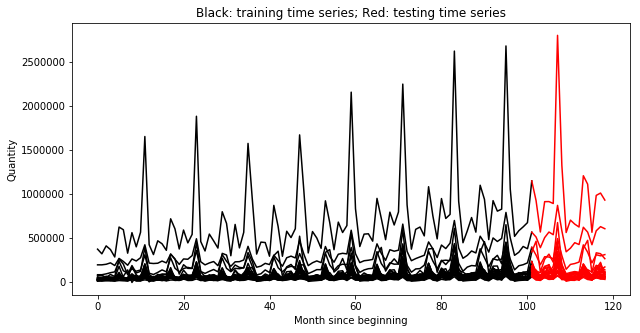

In [5]:
# Plot dataset
plt.figure(figsize=(10,5))
plt.plot(ts[:train_length,:,0], 'k')
plt.plot(range(len(ts[:train_length-1,:,0]), len(ts)), ts[train_length-1:,:,0], 'r')
plt.xlabel('Month since beginning')
plt.ylabel('Quantity')
plt.title('Black: training time series; Red: testing time series')

## Temporal Convolutional Neural Network Forecaster with Uncertainty

We choose the temporal CNN, which uses one-dimensional convolutions for modeling purposes.

In [6]:
# Hyper-parameters
topology = [
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c1', 'parent_ids': ['input']},
        'params': {'filters': 64, 'kernel_size': 5, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c2', 'parent_ids': ['c1']},
        'params': {'filters': 64, 'kernel_size': 3, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Conv1D', 'layer_id': 'c3','parent_ids': ['c2']},
        'params': {'filters': 128, 'kernel_size': 3, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Flatten', 'layer_id': 'f1', 'parent_ids': ['c3']},
        'params': {}
    },
    {
        'meta': {'layer_type': 'Dense', 'layer_id': 'd1', 'parent_ids': ['f1']
        },
        'params': {'units': 128, 'activation': 'elu'}
    },
    {
        'meta': {'layer_type': 'Dense', 'layer_id': 'd2', 'parent_ids': ['d1']},
        'params': {'units': 128, 'activation': 'elu'}
    }
]

# Instantiate regression model
forecaster = Forecaster(
    topology,
    optimizer='sgd',
    lag=lag,
    horizon=1,
    batch_size=8,
    epochs=2500,
    uncertainty=True,
    dropout_rate = 0.25,
    lr=0.1
)
forecaster.fit(ts_train)

Let's have a peek at what the model training and testing errors look like

In [7]:
criticize_model(forecaster, metric)

TRAIN 	 Mean Absolute Percentage Error: 23.6%
TEST 	 Mean Absolute Percentage Error: 19.1%


Let's have a look at the history of the training loss (here mean-squared error)

Text(0,0.5,'Mean-squared training error')

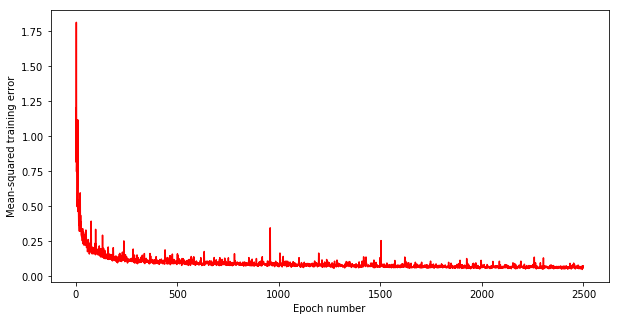

In [8]:
# Plot training error history
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r') 
plt.xlabel('Epoch number')
plt.ylabel('Mean-squared training error')

### Prediction with uncertainty by adding MC Dropout

In [9]:
ts_pred = forecaster.predict(ts_test, n_samples=100)
ts_pred_mean = ts_pred['mean']
ts_pred_median = ts_pred['median']
ts_pred_upper_quantile = ts_pred['upper_quantile']
ts_pred_lower_quantile = ts_pred['lower_quantile']
ts_pred_samples = ts_pred['samples']

Plot of prediction samples of test set including uncertainty bounds

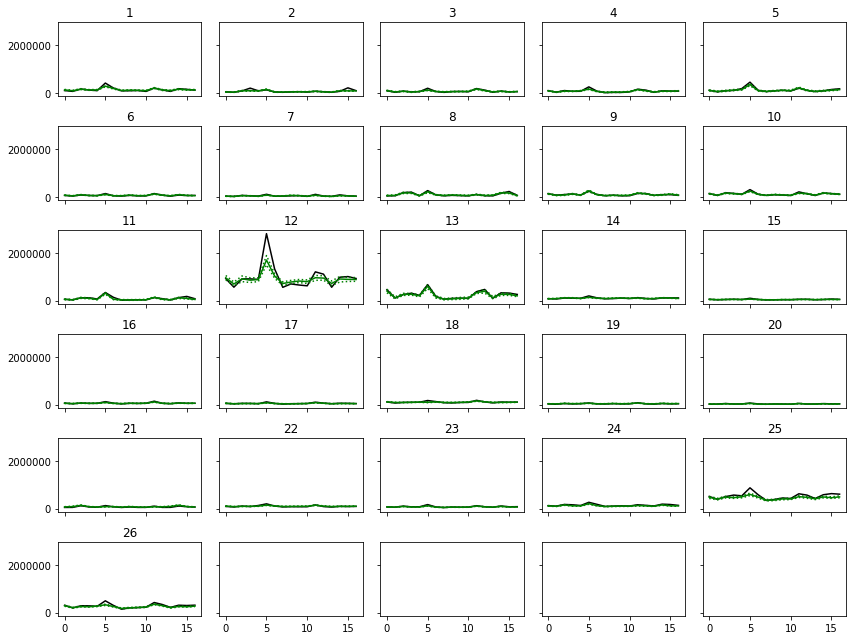

In [10]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, sharey=True, figsize=(12, 9))
for ax, ya, yp, yp_upper, yp_lower, title in zip(axes.flat, 
                                                 ts[train_length:,:,0].T, 
                                                 ts_pred_mean[:,:,0].T, 
                                                 ts_pred_upper_quantile[:,:,0].T, 
                                                 ts_pred_lower_quantile[:,:,0].T, 
                                                 range(1,26+1)):
    ax.plot(ya, 'k-')
    ax.plot(yp, 'g-')
    ax.plot(yp_lower, 'g:')
    ax.plot(yp_upper, 'g:')
    ax.set_title(title)

plt.tight_layout()